In [1]:
import os
import re
import imageio as iio
from pathlib import Path
import numpy as np
from glob import glob
import matplotlib.cm as cm
import matplotlib.pyplot as plt

#AIRXD model import

from airxd_cnn.cnn import ARIXD_CNN as cmodel
from airxd.dataset import Dataset, parse_imctrl
from torchvision.transforms import v2
import torch

In [2]:
def plot_im_and_mask(image_path, mask_path):
    #Load image and mask
    image = iio.v2.volread(image_path)
    mask = iio.v2.volread(mask_path)

    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(image, cmap='binary', origin='lower',)
    ax[0].set_title('Raw data')
    ax[0].axis('off')
    ax[1].imshow(mask, cmap='binary', origin='lower',)
    ax[1].set_title('Mask')
    ax[1].axis('off')

In [3]:
def plot_im_diff(image_path_1, image_path_2):
    #Load image and mask
    image1 = iio.v2.volread(image_path_1)
    image2 = iio.v2.volread(image_path_2)

    fig, ax = plt.subplots(1,1, figsize=(10,10))
    im = ax.imshow(np.log(np.abs(image1-image2)), cmap='binary', origin='lower',)
    fig.colorbar(im, location='right')
    ax.set_title('Raw data')
    ax.axis('off')

In [4]:
def retrieve_norm_image(base_dir, dataset_name, i):
    file_paths = glob('data/' + dataset_name + '/*.tif')
    file_paths.sort()
    file_i = glob(base_dir + os.path.basename(file_paths[i])[:-4] + '*.tif')[0]

    return iio.v2.volread(file_i)

In [14]:
#Glob all tif files in the path 'data/battery1/*.tif'

#Get all the file paths
file_paths = glob('data/battery3/*.tif')
mask_paths = glob('data/battery3/masks/*.tif')

#Sort both paths
file_paths.sort()
mask_paths.sort()


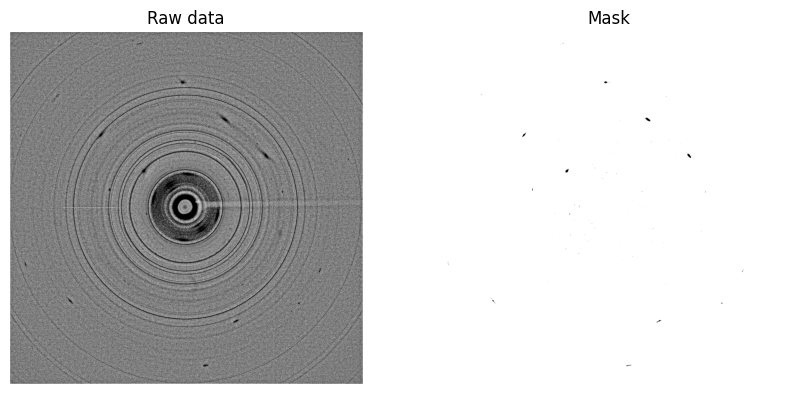

In [15]:
i = 1

#Get last file name separated by / in file_paths[i]

base_dir = 'data/normalized_train/'

file_oi = glob(base_dir + os.path.basename(file_paths[i])[:-4] + '*.tif')

plot_im_and_mask(file_oi[0], mask_paths[i])



# Checking for battery2 whether many of the labelled regions have extremely small areas

In [16]:
from scipy.ndimage import label
from skimage.measure import regionprops

In [17]:
def filter_connected_components_by_size(mask, min_size, max_size=None):
    """
    Filters connected components in the mask based on size.
    
    Parameters:
        mask (ndarray): Binary mask where spots are marked as 1, and the background is 0.
        min_size (int): Minimum number of pixels for a connected component to be kept.
        max_size (int, optional): Maximum number of pixels for a connected component to be kept. If None, no upper limit.
        
    Returns:
        filtered_mask (ndarray): Mask with only the connected components that meet the size criteria.
    """
    # Label each connected component in the binary mask
    labeled_mask, _ = label(mask)
    
    # Initialize an empty mask to hold the filtered components
    filtered_mask = np.zeros_like(mask)
    
    # Get properties of labeled regions
    regions = regionprops(labeled_mask)
    
    for region in regions:
        # Check the size of each region
        region_size = region.area
        if region_size >= min_size and (max_size is None or region_size <= max_size):
            # Add this region to the filtered mask
            filtered_mask[labeled_mask == region.label] = 1
    
    return filtered_mask


In [40]:
i = 1
exp = 'battery2'
mask_paths = glob('data/' + exp + '/masks/*.tif')
mask = iio.v2.volread(glob('data/' + exp + '/masks/' + os.path.basename(mask_paths[i]))[0])

size_thresh = 50

filtered_mask = filter_connected_components_by_size(mask, 20)

In [41]:
np.sum(filtered_mask) / np.sum(mask)

0.47996250292945863

In [42]:
small_island_mask = (np.ones_like(mask) - filtered_mask) * mask

Text(0.5, 1.0, 'Filtered Mask with islands < 5 pixels')

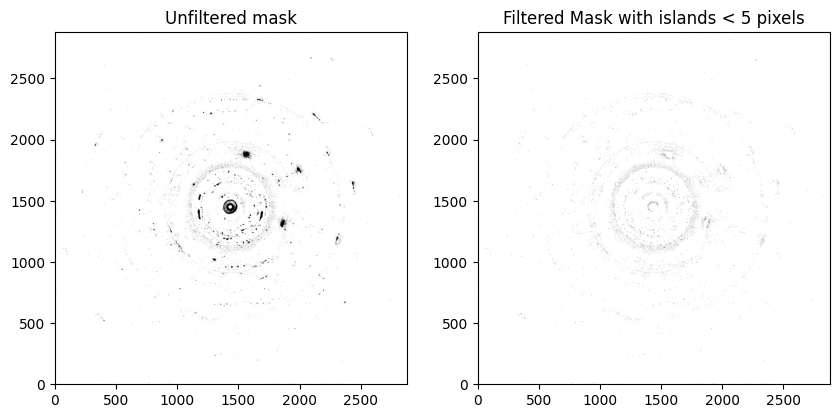

In [43]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(mask, cmap='binary', origin='lower')
ax[0].set_title(f'Unfiltered mask')
# ax[1].imshow(filtered_mask, cmap='binary', origin='lower')
# ax[1].set_title(f'Filtered Mask with islands > {size_thresh} pixels')
ax[1].imshow(small_island_mask, cmap='binary', origin='lower')
ax[1].set_title(f'Filtered Mask with islands < 5 pixels')

# Applying mask area filtering to battery2

In [45]:
mask_paths = glob('data/battery2/masks/*.tif')

size_thresh = 30
for mask_path in mask_paths:
    mask = iio.v2.volread(mask_path)
    filtered_mask = filter_connected_components_by_size(mask, 20)
    iio.imwrite(mask_path, filtered_mask)
    

ValueError: Image must be 3D, or 4D if each voxel is a tuple.

/tmp/ipykernel_3400463/492765738.py:7: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(np.abs(image1-image2)), cmap='binary', origin='lower',)


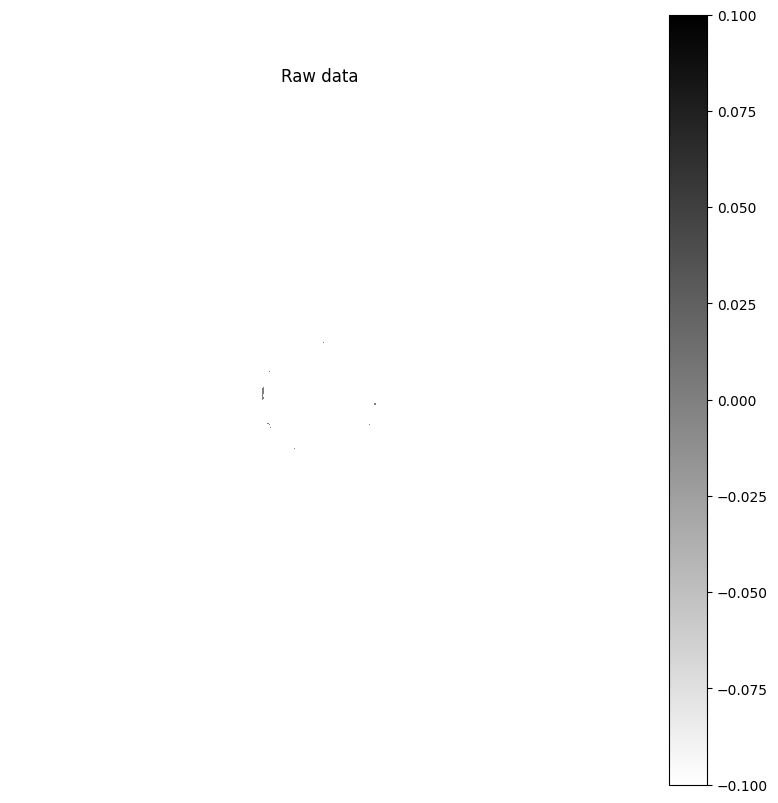

In [13]:
i = 10
j = 1

exp = 'battery2'

#Get last file name separated by / in file_paths[i]

base_dir = 'data/normalized_train/'

file_i = glob(base_dir + os.path.basename(file_paths[i])[:-4] + '*.tif')[0]
file_j = glob(base_dir + os.path.basename(file_paths[j])[:-4] + '*.tif')[0]

mask_i = glob('data/' + exp + '/masks/' + os.path.basename(mask_paths[i]))[0]
mask_j = glob('data/' + exp + '/masks/' + os.path.basename(mask_paths[j]))[0]

plot_im_diff(mask_i, mask_j)



Computing image entropies... why do these images perform so much better?

In [57]:
i = 4
base_dir = 'data/normalized_train/'
file_i = glob(base_dir + os.path.basename(file_paths[i])[:-4] + '*.tif')[0]

len(np.unique(iio.v2.volread(file_i)))

256

In [58]:
import scipy.stats

In [66]:
def image_entropy(im):
    
    p=np.histogram(im, bins=256, range=(0,1), density=True)[0]

    return scipy.stats.entropy(p, base=2)

In [65]:
np.max(im.flatten())

0.99609375

In [94]:
i = 8
im = retrieve_norm_image('data/normalized_train/',
                         'Nickel',
                         i)

image_entropy(im.flatten())


7.910510938209597

Trying mutual information instead...

In [105]:
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score

In [108]:
def MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    return mutual_info_score(None,None, contingency=c_xy)

In [150]:
#Calculate entire MI matrix
exp_name = 'battery4'
n_exp = len(glob('data/' + exp_name + '/*.tif'))
MI_matrix = np.zeros((n_exp, n_exp))

for i in range(n_exp):
    im_i = retrieve_norm_image('data/normalized_train/', exp_name, i)
    for j in range(i+1,n_exp):
        im_j = retrieve_norm_image('data/normalized_train/', exp_name, j)
        
        MI_matrix[i,j] = MI(im_i.flatten(), im_j.flatten(), 256)
        MI_matrix[j,i] = MI_matrix[i,j]

MI_max = np.max(MI_matrix)

#Filling out for visual clarity
for i in range(n_exp):
    MI_matrix[i,i] = 0


In [146]:
for i in range(n_exp):
    MI_matrix[i,i] = 0

MI_matrix[10,9] = 0
MI_matrix[9,10] = 0


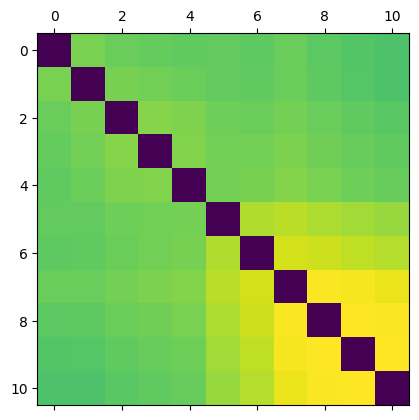

In [149]:
plt.matshow(MI_matrix)

In [136]:
MI_matrix

array([[0.        , 0.06103815, 0.06094445, 0.06117918, 0.06091913,
        0.0610686 , 0.06101763, 0.06115877, 0.06106518, 0.06088817,
        0.06086353, 0.06099725],
       [0.06103815, 0.        , 0.06095356, 0.06102079, 0.06079357,
        0.06082215, 0.06087477, 0.06075165, 0.06097967, 0.06087241,
        0.0609688 , 0.06093411],
       [0.06094445, 0.06095356, 0.        , 0.0610388 , 0.06166193,
        0.0608617 , 0.06084753, 0.06102608, 0.06110131, 0.06126378,
        0.06135049, 0.06157616],
       [0.06117918, 0.06102079, 0.0610388 , 0.        , 0.06096887,
        0.06106227, 0.06126821, 0.06099854, 0.06102475, 0.06097586,
        0.06094202, 0.06094213],
       [0.06091913, 0.06079357, 0.06166193, 0.06096887, 0.        ,
        0.0607303 , 0.06086393, 0.06092866, 0.0610765 , 0.06126477,
        0.06122439, 0.06143074],
       [0.0610686 , 0.06082215, 0.0608617 , 0.06106227, 0.0607303 ,
        0.        , 0.06095533, 0.06086913, 0.06080899, 0.06081834,
        0.06083877,